#### Libraries:

In [1]:
%load_ext rpy2.ipython
%R library(dplyr); library(ggplot2); library(gridExtra); library(vegan)

//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
//anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **n

array(['vegan', 'lattice', 'permute', 'gridExtra', 'ggplot2', 'dplyr',
       'tools', 'stats', 'graphics', 'grDevices', 'utils', 'datasets',
       'methods', 'base'], 
      dtype='|S9')

#### Functions: The below functions can be run on their own to create the dataframes and component plots used to create the final heatmap.  These functions need to be loaded to run the final heatmap-creating function.

In [2]:
%%R
# this function combines a list of final output tables form sag-mg-recruit
combine_smr_tables <- function(tablelist){
    all<-data.frame()
    for (t in tablelist){
        df = read.table(t, sep="\t", header=TRUE)
        all <- rbind(all, df) 
        }
    return(all)
    }

# returns a table with a row per metagenome that summarises metagenome overall representation
# reads_per_mbp: number of metagenomic reads recruited per mpb
# prop_mgreads_per_mbp: proportion total meteganome reads recruited per total_sag_mbp
# pct_metagenome: percent metagenomic reads recruited to all sags** this value will be the bar plot 
# underneath the y-axis of the heatmap

summarise_mgs <- function(df){
    mg_summary <- df %>% filter(sag == "concatenated_sags") %>% .[,c(1:8)]
    total_sag_bp <- all %>% .[,c(1,10)] %>% unique %>% filter(sag != "concatenated_sags") %>% .[,2] %>% sum 
    mg_summary$total_sag_bp <- total_sag_bp
    mg_summary$sag_size_mbp <- total_sag_bp/1000000
    mg_summary <- mg_summary %>% mutate(reads_per_mbp=total_reads_recruited/sag_size_mbp, 
                                        prop_mgreads_per_mbp=(total_reads_recruited/sag_size_mbp)/mg_read_count,
                                       pct_metagenome=(total_reads_recruited/mg_read_count)*100)
    underplot <- mg_summary[,c(2,ncol(mg_summary))]
    return(underplot)
}



# summarise the number of total mg reads recruited to each SAG
# for the side plot of the heatmap

summarise_sags <- function(pairs){
    total_mg_reads <- pairs[,8] %>% unique %>% sum
    sideplot <- pairs %>% group_by(sag) %>% summarise(pct_reads_recruited_allmgs = (sum(total_reads_recruited)/total_mg_reads)*100)
    return(sideplot)
}


# process an input file defining the order in which sags or mgs appear 
# in the final heatmap
import_order <- function(file_path){
    order <- read.table(file_path, header=TRUE)
    order$levels <- seq(1, nrow(order))
    return(order)
}

# Plot fuctions 
main_heatmap <- function(pairs, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){

    p1 <- pairs %>% ggplot(aes(metagenome, sag)) + geom_tile(aes(fill=prop_mgreads_per_mbp)) + theme_bw() 
    pmain <- p1 + theme(axis.ticks = element_blank(), axis.title.x=element_blank(), axis.text.x=element_blank())
    pmain <- pmain + labs(x=" ", fill="") + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    pmain <- pmain  + theme(legend.key.height=unit(50, "pt"), legend.position="none") 
    pmain <- pmain + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank()) 
    return(pmain)
}

# plot legend for heatmap separately from the heatmap itself: 
hm_legend <- function(pairs, lowcolor="white",midcolor="lightblue", highcolor="darkblue"){
    
    legend <- pairs %>% ggplot(aes(metagenome, sag)) + geom_blank(aes(fill=prop_mgreads_per_mbp))
    legend <- legend + theme(axis.text = element_blank(),
                    axis.title = element_blank(),
                    line = element_blank(),
                    panel.background = element_blank()) + labs(fill="")
    legend <- legend + theme(legend.key.width=unit(80, "pt"), 
                             legend.position=c(.5, .5), 
                     legend.direction="horizontal") 
    legend <- legend + scale_fill_gradientn(colours=c(lowcolor,midcolor,highcolor), values=c(0,0.00001,1))
    return(legend)

}

# function to create the bar plot that sits underneath the heatmap
mg_plot <- function(df, mgorder="None"){
    underplot <- summarise_mgs(df)
    if (mgorder != "None"){
        underplot$metagenome <- with(underplot, factor(metagenome, levels=mgorder[,1]))
    }
    u <- underplot %>% ggplot(aes(metagenome, pct_metagenome)) + geom_bar(stat="identity", fill="white", color="black") +  scale_y_reverse()
    u <- u + theme(axis.line.y = element_line(color="black"))+ scale_x_discrete() 
    punder <- u + labs(y="", x="") + theme(axis.text.x  = element_text(angle=90, face="bold"))
    punder <- punder + theme(panel.border = element_blank(), 
                             panel.grid.major = element_blank(),
                             panel.grid.minor = element_blank(), 
                             panel.background = element_blank(), 
                             axis.ticks = element_blank(),
                             axis.line.y = element_line(color="black"),
                             axis.text.x = element_blank()) # remove this if you want axis labels for the y-axis
    return(punder)
    }

# function to create the bar plot that sits to the left of the heatmap
sag_plot <- function(df, sagorder="None"){
    sideplot <- summarise_sags(df)
    if (sagorder != "None"){
        sideplot$sag <- with(sideplot, factor(sag, levels=sagorder[,1]))
    }
    s <- sideplot %>% ggplot(aes(sag, pct_reads_recruited_allmgs)) + geom_bar(stat="identity", fill="white", color="black") +  theme_classic()+ coord_flip()
    pside <- s + theme(axis.ticks = element_blank(), axis.text.y = element_blank(), axis.title = element_blank())
    pside <- pside + theme(axis.text.x = element_text(angle = -90))
    pside <- pside + theme(panel.border = element_blank(), 
                           panel.grid.major = element_blank(),
                           panel.grid.minor = element_blank(), 
                           panel.background = element_blank(),
                           axis.line.x = element_line(color="black")) 
    return(pside)

}

# empty plot required for creating the plot array
empty_plot <- function(df){
    pempty <-ggplot(df, aes(sag, metagenome)) + geom_blank() + theme(axis.text = element_blank(),
                axis.title = element_blank(),
                line = element_blank(),
                panel.background = element_blank())
    return(pempty)
}

# creates an adjacency table from an edgelist; needed for clustering
create_adjtbl <- function(edgelist){
    yaxis = unique(edgelist[,2])
    xaxis = unique(edgelist[,1])
    together <- data.frame(xaxis)
    colnames(together)[1] <- colnames(edgelist)[1]
    for (m in seq(1,length(yaxis))){
        es <- edgelist %>% filter(.[,2]==yaxis[m])
        colnames(es)[3] <- as.character(yaxis[m])
        to_combine <- data.frame(es[,3])
        colnames(to_combine)[1] <- colnames(es)[3]
        #together = merge(together, to_combine, by=colnames(together)[1])
        together = cbind(together, to_combine)
    }
    return(together)
    }

# sets the order based on heirarchical clustering
clust_order_x <- function(edgelist){
    adj <- create_adjtbl(edgelist)
    rownames(adj) <- adj[,1]
    adj[,1] <- NULL
    mat1 <- as.matrix(adj)
    xdist <- mat1 %>% vegdist(method="bray") 
    xdist[is.na(xdist)] <- 1
    xdist %>% hclust -> xclust
    xdend <- as.dendrogram(xclust)
    xorder1 <- order.dendrogram(xdend)
    data <- mat1[xorder1,]
    levels <- seq(1, nrow(data))
    xorder <- cbind.data.frame(rownames(data), levels)
    colnames(xorder)[1] <- colnames(edgelist)[1]
    return(xorder)
    }

Below this is the main function (plot_array) that will put the arrayed heatmap plot together.  The only required parameter is the input dataframe, which can either directly come from sag-mg-recruit, or be a combination of results from serveral sag-mg-recruit runs combined using the function: ```combine_smr_tables```.

To change the alignment of the plots, change the 

```sag_ax_aln```, ```hm_aln```, and ```mg_ax_aln``` values.  

You can set the colors by changing ```lowcolor```, ```midcolor``` and ```highcolor```.

To cluster the sags/mgs based on bray-curtis distance and heirarchical clustering, input ```hclust_sags=TRUE```, ```hclust_mgs=TRUE``` (default is ```FALSE```)

To manually input sag or mg order, enter the **path** to an order file.  The order file should have with one mg/sag per line in the order that you'd like them to appear on the plot.

In [10]:
%%R

plot_array <- function(df,
                       sag_ax_aln = 0,
                       hm_aln = 28,
                       mg_ax_aln = 105,
                       lowcolor="white",
                       midcolor="lightblue", 
                       highcolor="darkblue",
                       hclust_sags = FALSE,
                       hclust_mgs = FALSE,
                       sag_order = "None",
                       mg_order = "None"){
    mgplot <- mg_plot(df)
    pairs <- df %>% filter(sag != "concatenated_sags")
    
    if (hclust_sags==TRUE){
        sagorder = clust_order_x(pairs[,c(1,2,13)])
        sagplot <- sag_plot(pairs, sagorder=sagorder)
        pairs$sag <- with(pairs, factor(sag, levels=sagorder[,1]))
    } else if (sag_order != "None"){
        sag_order = import_order(sag_order)
        sagplot <- sag_plot(pairs, sagorder = sag_order)
    } else {
        sagplot <- sag_plot(pairs)
    }
    
    if (hclust_mgs==TRUE){
        mgorder = clust_order_x(pairs[,c(2,1,13)])
        mgplot <- mg_plot(df, mgorder=mgorder)
        pairs$metagenome <- with(pairs, factor(metagenome, levels=mgorder[,1]))
    } else if (mg_order != "None"){
        mg_order = import_order(mg_order)
        mgplot <- mg_plot(df, mgorder = mg_order)
    } else {
        mgplot <- mg_plot(df)
    }
    
    heatmap <- main_heatmap(pairs, lowcolor=lowcolor, midcolor=midcolor, highcolor=highcolor)
    empty <- empty_plot(df)
    legend <- hm_legend(pairs, lowcolor=lowcolor, midcolor=midcolor, highcolor=highcolor)
    heatmap <- heatmap + theme(plot.margin=unit(c(0,0,hm_aln,0), "pt"))
    mgplot <- mgplot + theme(plot.margin=unit(c(-hm_aln,0,0,mg_ax_aln),"pt"))
    sagplot <- sagplot + theme(plot.margin=unit(c(0,0,sag_ax_aln,0), "pt")) #+ theme(plot.margin=unit(c(0,0,-25,0), "pt"))
    empty <- empty + theme(plot.margin=unit(c(50,0,0,0), "pt"))
    legend <- legend + theme(plot.margin=unit(c(0,0,0,mg_ax_aln), "pt"))
    
    final <- grid.arrange(heatmap, sagplot, mgplot, empty, legend, empty,
             ncol = 2, nrow = 3, widths = c(6, 1), heights = c(8, 2, 1))
    return(final)
    
    }

# Example plots using the above functions:

First, gather the tables you wish to combine into a list:

In [4]:
import glob
# this is a python trick to get paths to all files that follow a specific name convention

tablelist = glob.glob("../data/Maria_smr_tables/*overlap0.txt")
tablelist

['../data/Maria_smr_tables/ETSP_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/LineP_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/Malaspina47_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/Med_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/NA_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/SI_summary_table_pctid95_minlen100_overlap0.txt',
 '../data/Maria_smr_tables/Takuro_summary_table_pctid95_minlen100_overlap0.txt']

Import the tablelist into R and combine all tables into one using the "combine_smr_tables" function:

In [5]:
%%R -i tablelist 

all <- combine_smr_tables(tablelist)
head(all) %>% print

         sag      metagenome Percent_scaffolds_with_any_coverage
1 AAA008-D05  Mex_OMZ_St6_30                                  NA
2 AAA008-D05  Mex_OMZ_St6_85                                 100
3 AAA008-D05 Mex_OMZ_St6_100                                 100
4 AAA008-D05 Mex_OMZ_St6_125                                 100
5 AAA008-D05 Mex_OMZ_St6_300                                 100
6 AAA008-D05 Mex_OMZ_St10_30                                  NA
  Percent_of_reference_bases_covered Average_coverage total_reads_recruited
1                           0.000000       0.00000000                     0
2                          32.390782       0.54146206                  1384
3                          14.190358       0.21449131                   490
4                           3.412210       0.06635864                    81
5                           1.696131       0.04579196                    59
6                           0.000000       0.00000000                     0
  mg_wgs_tech

In [6]:
%%R
# I noticed that some rows appear more than once in these tables, 
# so using only the unique rows 
# (if rows aren't unique, you'll get an error in the main function)

all %>% nrow %>% paste("there are", .,"TOTAL rows in the combined table") %>% print
all %>% unique %>% nrow %>% paste("there are", .,"UNIQUE rows in the combined table") %>% print
all %>% unique -> all

[1] "there are 6235 TOTAL rows in the combined table"
[1] "there are 6106 UNIQUE rows in the combined table"


Now plot the dataframe.  
*Notice that I'm setting the dimensions of the output plot at the top of the cell when I invoke R*

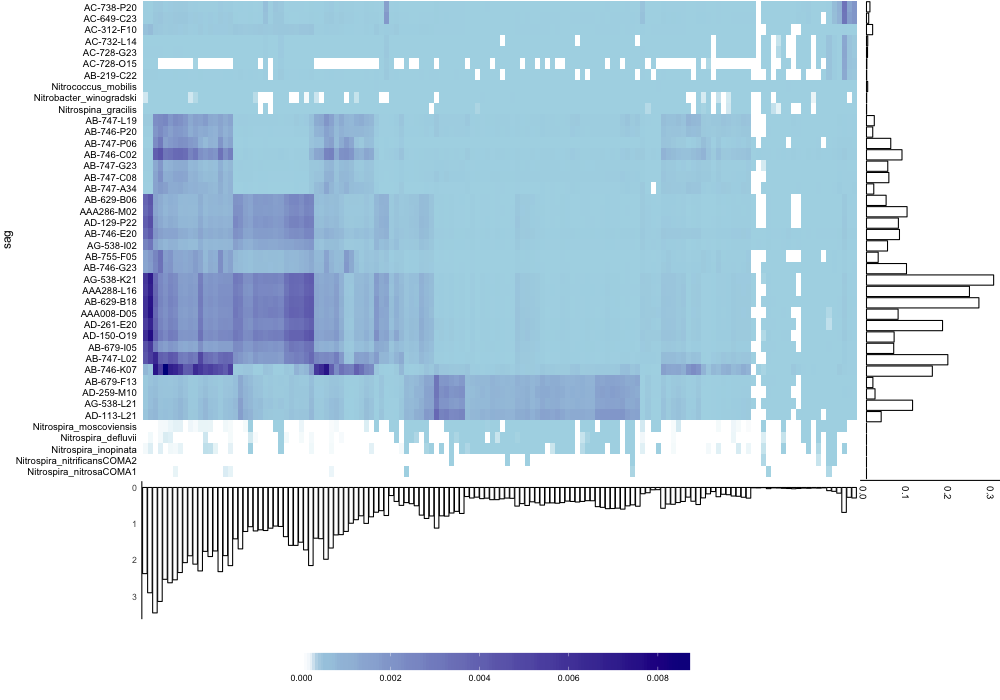

In [12]:
%%R -w 1000 -h 700 
# -w and -h sets the dimensions of the plot output
# helps you visualize plot dimensions before writing them to a file

# to plot a clustered heatmap:

clustered <- plot_array(all, sag_ax_aln = 10, mg_ax_aln=118, hclust_sags=TRUE, hclust_mgs=TRUE)

*I've changed the sag_ax_aln and mg_ax_aln numbers slightly from the defaults to align the bar plots with the heat map axes.  You will have to do a bit of trial and error messing around with these numbers to get the axes aligned*

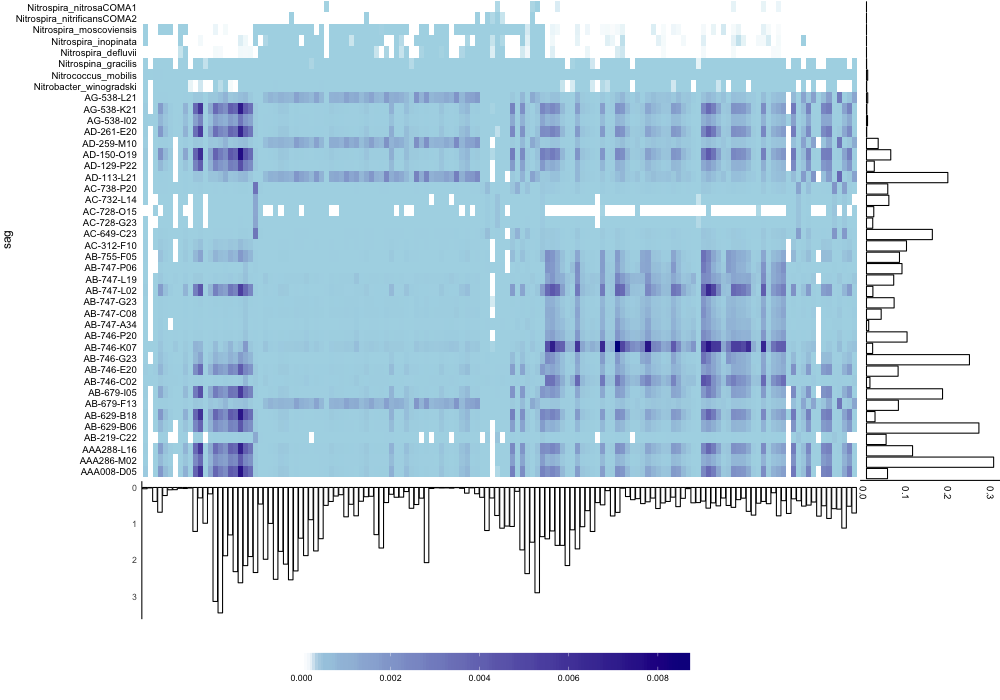

In [13]:
%%R -w 1000 -h 700
#to plot a heatmap where placement is directed:

directed <- plot_array(all, sag_ax_aln = 10, mg_ax_aln=118, hclust_sags=FALSE, hclust_mgs=FALSE, 
           mg_order="../data/Maria_smr_tables/order/mg_order.csv", 
           sag_order="../data/Maria_smr_tables/order/sag_order.csv")

Once you're happy with with your plots, you can send them to an output file using the below commands:

In [92]:
%%R
# this is the script to use to write these plots to png files
# notice that the "width" and "height" parameters are the same as the -w and -h parameters above

png(filename = "../data/directed_heatmap.png",
   width=1000, height=700, units="px")
plot(directed)
dev.off()

quartz_off_screen 
                2 


In [91]:
%%R
png(filename = "../data/clustered_heatmap.png",
   width=1000, height=700, units="px")
plot(clustered)
dev.off()

quartz_off_screen 
                2 


Change heatmap colors:

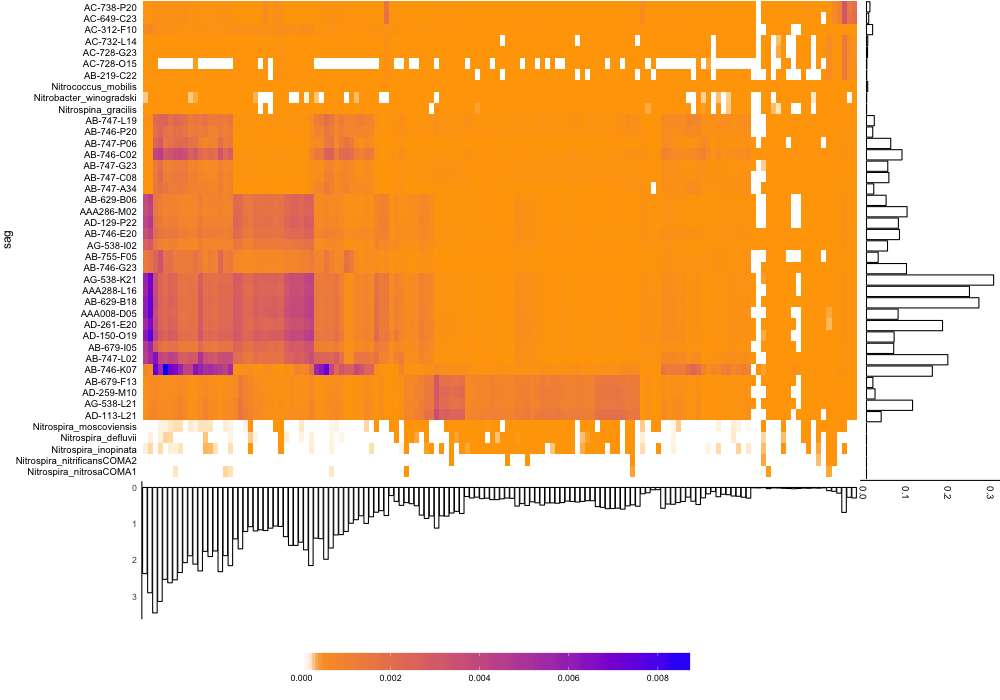

In [15]:
%%R -h 700 -w 1000
directed <- plot_array(all, sag_ax_aln = 10, mg_ax_aln=118, hclust_sags=TRUE, hclust_mgs=TRUE,
                       lowcolor="white", midcolor="orange", highcolor="blue")